In [5]:
from google.colab import files
uploaded = files.upload()

Saving IMDB Dataset.csv to IMDB Dataset.csv


In [6]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [7]:
import io
df = pd.read_csv('IMDB Dataset.csv')



In [8]:
import re
from bs4 import BeautifulSoup
import string

def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Lowercasing
    text = text.lower()

    # Remove special characters, punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Handling contractions (example)
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    # Add more contraction expansions as needed

    return text

In [9]:
df['cleaned_review'] = df['review'].apply(lambda x: clean_text(x))

<ipython-input-8-8bcc12f2e336>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [10]:
X = df['cleaned_review'].values
y = df['sentiment'].values

In [11]:
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)

In [12]:
max_length = 300
X_padded = pad_sequences(X_seq, maxlen=max_length, padding='post')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [14]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [15]:
embedding_dim = 80

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_length),
    LSTM(units=120),
    Dropout(0.5),
    Dense(units=1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 80)           800000    
                                                                 
 lstm (LSTM)                 (None, 120)               96480     
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense (Dense)               (None, 1)                 121       
                                                                 
Total params: 896601 (3.42 MB)
Trainable params: 896601 (3.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5)
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', mode='min', save_best_only=True)

history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stop, checkpoint])







Epoch 1/30
2500/2500 [==============================] - 115s 43ms/step - loss: 0.6822 - accuracy: 0.5321 - val_loss: 0.6749 - val_accuracy: 0.5370
Epoch 2/30
  11/2500 [..............................] - ETA: 30s - loss: 0.6476 - accuracy: 0.5568

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2500/2500 [==============================] - 44s 18ms/step - loss: 0.5806 - accuracy: 0.7011 - val_loss: 0.5232 - val_accuracy: 0.7772
Epoch 3/30
2500/2500 [==============================] - 42s 17ms/step - loss: 0.5141 - accuracy: 0.7819 - val_loss: 0.5419 - val_accuracy: 0.7707
Epoch 4/30
2500/2500 [==============================] - 39s 16ms/step - loss: 0.4783 - accuracy: 0.7892 - val_loss: 0.4725 - val_accuracy: 0.8055
Epoch 5/30
2500/2500 [==============================] - 41s 16ms/step - loss: 0.3277 - accuracy: 0.8633 - val_loss: 0.2875 - val_accuracy: 0.8836
Epoch 6/30
2500/2500 [==============================] - 40s 16ms/step - loss: 0.2346 - accuracy: 0.9097 - val_loss: 0.2771 - val_accuracy: 0.8876
Epoch 7/30
2500/2500 [==============================] - 38s 15ms/step - loss: 0.1826 - accuracy: 0.9328 - val_loss: 0.2803 - val_accuracy: 0.8896
Epoch 8/30
2500/2500 [==============================] - 39s 16ms/step - loss: 0.1503 - accuracy: 0.9450 - val_loss: 0.3286 - val_accura

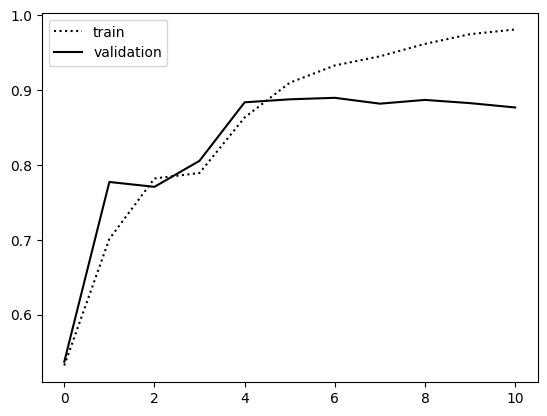

In [17]:
import matplotlib.pyplot as plt
import tensorflow as tf
plt.plot(history.history['accuracy'], linestyle='dotted',color='black', label='train')
plt.plot(history.history['val_accuracy'], linestyle='solid',color='black', label='validation')
plt.legend()





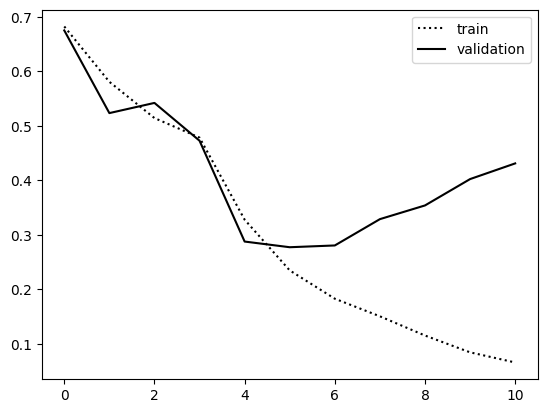

In [18]:
plt.plot(history.history['loss'], linestyle='dotted',color='black', label='train')
plt.plot(history.history['val_loss'], linestyle='solid',color='black', label='validation')
plt.legend()

In [21]:
model = tf.keras.models.load_model('model.h5')
model.evaluate(X_test, y_test)

test_predictions = model.predict(X_test)

bin_predictions = (test_predictions >= 0.5).astype(int)

classification_report(y_test, bin_predictions)
confusion_matrix(y_test, bin_predictions)

313/313 [==============================] - 2s 5ms/step


array([[4344,  617],
       [ 507, 4532]])

In [23]:
print(classification_report(y_test, bin_predictions))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

